In [ ]:
# Set this variable to 1 for all images to be black and white
blackandwhite = 0

# Set this variable to change all fontsizes (e.g. 23 for large text)
# Set it to 0 to give same fontsizes as in the paper
fontsizeglob = 0

# Imports
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.special import lambertw
from matplotlib.pyplot import cm
import matplotlib.ticker as tkr
from fractions import Fraction

In [ ]:
# Functions for computing bounds

# Zero function (for plotting functions without comparison)
def zero_func(q,p):
  return 0

# Function for finding supremum of B(...), given a comparator
def num_opt(trainloss, boundrhs, comp_func):
  def con(R):
    return ( boundrhs - comp_func(trainloss,R) ) * R
  objective = lambda R: -R
  cons = ({'type': 'ineq', 'fun' : con})
  results = opt.minimize(objective,x0=trainloss+0.1,constraints = cons,options = {'disp':False})
  bound = results.x[0]
  return bound

# Approximately minimize the MLS bound over [0,1] (avoids instability)
def mlsfast(q, boundrhs):
  Rrange = np.linspace(0.01,0.999,500)
  klrange = q*np.log(q/Rrange) + (1-q)*np.log( (1-q)/(1-Rrange) )
  violbound = klrange > boundrhs
  Rrange[ violbound ] = 0
  return np.max( Rrange )

# Sub-Gaussian bound for bounded losses
def diffbounded(trainloss, boundrhs):
  return np.min( [trainloss + np.sqrt( boundrhs/2 ) , 1] )

# Our bound for sub-Poissonian losses
def ourpoisson(trainloss, boundrhs):
  return ( trainloss + boundrhs ) / np.real(lambertw( ( (trainloss + boundrhs)*np.exp(1) )/trainloss ))

# Bound for sub-Poisson based on difference-comparator
def diffpoissonfast(trainloss, boundrhs):
  tvec = np.linspace(0.01,300,10000)
  yvec = tvec*trainloss/(1-np.exp(-tvec)) + boundrhs/(1-np.exp(-tvec))
  return np.min(yvec)

# Sub-Gaussian bound without min (potentially unbounded losses)
def diffbounded_nomin(trainloss, boundrhs):
  return  trainloss + np.sqrt( boundrhs/2 )

# Our bound for sub-gamma losses
def ourgamma(trainloss, boundrhs):
  k = 5
  def gammacomp(q,p):
    return k * ( q/p - 1 - np.log(q/p) )
  return num_opt(trainloss,boundrhs,gammacomp)

# Our bound for sub-Laplacian losses
def ourlaplace(trainloss, boundrhs):
  b = 1
  def laplacecomp(q,p):
    sqrtterm = np.sqrt( (q-p)**2 + b**2 )
    return sqrtterm/b - 1 + np.log( 2*( b*sqrtterm - b**2 ) / (q-p)**2 )
  return num_opt(trainloss,boundrhs,laplacecomp)

# Our bound for sub-inverse Gaussian losses
def ourinvgauss(trainloss, boundrhs):
  lamb = 1
  def invgausscomp(q,p):
    return lamb * (p-q)**2 / (2 * p * q**2)
  return num_opt(trainloss,boundrhs,invgausscomp)

# Our bound for sub-negative binomial losses
def ournegbin(trainloss, boundrhs):
  r = 3
  def negbincomp(q,p):
    return r * np.log( (p+r) / (q+r) ) + q * np.log( (q*(p+r)) / (p*(q+r)) )
  return num_opt(trainloss,boundrhs,negbincomp)

In [ ]:
# Heatmap plotting function
def plot_heatmap( bound1, bound2 = zero_func, xmin = 0.01, xmax = 3,
                  Bmin = 0.01,Bmax = 3, numpoints = 150, cmap = cm.Greens,
                  fontsize = 15, colorbarformat = '%.2f'):

  if fontsizeglob > 0:
    fontsize = fontsizeglob
  if blackandwhite == 1:
    cmap = cm.Greys

  xvec = np.linspace(xmin, xmax, numpoints)
  Bvec = np.linspace(Bmin, Bmax, numpoints)
  yvec = np.zeros( (numpoints,numpoints) )
  yvecdiff = np.zeros_like(yvec)

  for indx, x in enumerate(xvec):
    for indB, B in enumerate(Bvec):
      indxplace = numpoints - indx - 1
      yvec[indxplace,indB] = bound1( x , B )
      yvecdiff[indxplace,indB] = bound2( x , B )

  # If we have no comparison, we only plot the bound. Otherwise, bound2-bound1
  if bound2 == zero_func:
    yplot = yvec
  else:
    yplot = yvecdiff - yvec

  ax = plt.imshow( yplot , interpolation='nearest', cmap=cmap )

  numticks = 5
  plt.rcParams.update({'font.size': fontsize })
  plt.colorbar( format=tkr.FormatStrFormatter(colorbarformat) )
  plt.yticks(ticks = np.linspace(0,numpoints-1,numticks),
             labels = np.flip(np.linspace(0, xmax, numticks)) )
  plt.ylabel(r'Training loss', fontsize=fontsize )
  plt.xticks(ticks = np.linspace(0,numpoints-1,numticks),
             labels = np.linspace(0, Bmax, numticks))
  plt.xlabel(r'Normalized KL divergence', fontsize=fontsize )
  plt.show()

In [ ]:
# n-dependence plotting function, with optional asymptote inputs
def n_plot( bound_func, trainloss = 1, KL = 10**3, nminlog = 2, nmaxlog = 5,
           numpoints = 150, plotcolor = 'orange', fontsize = 17,
           boundlabel = 'Bound', initasymp = 0, KLasymp = 0, ymin=0, ymax = 0 ):

  if fontsizeglob > 0:
    fontsize = fontsizeglob
  if blackandwhite == 1:
    plotcolor = 'black'

  Nvec = np.logspace(nminlog,nmaxlog,num=numpoints)
  yvec = np.zeros_like( Nvec )

  for indN, N in enumerate(Nvec):
    boundrhs = KL / N
    yvec[indN] = bound_func( trainloss , boundrhs )

  plt.loglog(Nvec,yvec, color=plotcolor, label=boundlabel, lw=2)
  if ymax == 0:
    ylims = [0.8*yvec[-1], yvec[0]]
  else:
    ylims = [ymin, ymax]
  plt.ylim( ylims )

  if initasymp > 0:
    plt.loglog(Nvec, Nvec[0]**initasymp * yvec[0] / (Nvec**initasymp) , 'k--',
               label='$n^{{- {} }}$'.format( str(Fraction(str(initasymp)) )))

  if KLasymp > 0:
    plt.loglog(Nvec, KL**KLasymp * bound_func( trainloss , 1 ) / Nvec**KLasymp,
            'k-.', label='$n^{{- {} }}$'.format( str(Fraction(str(KLasymp)) )) )
    plt.loglog( [KL,KL], ylims, 'k:' )

  plt.legend()
  plt.rcParams.update({'font.size': fontsize})
  plt.ylabel(r'Bound on population loss', fontsize=fontsize)
  plt.xlabel(r'Number of training samples', fontsize=fontsize)
  plt.show()
  plt.clf()


<ipython-input-180-d296443e2cbb>:20: RuntimeWarning: divide by zero encountered in log
  klrange = q*np.log(q/Rrange) + (1-q)*np.log( (1-q)/(1-Rrange) )
<ipython-input-180-d296443e2cbb>:20: RuntimeWarning: invalid value encountered in multiply
  klrange = q*np.log(q/Rrange) + (1-q)*np.log( (1-q)/(1-Rrange) )


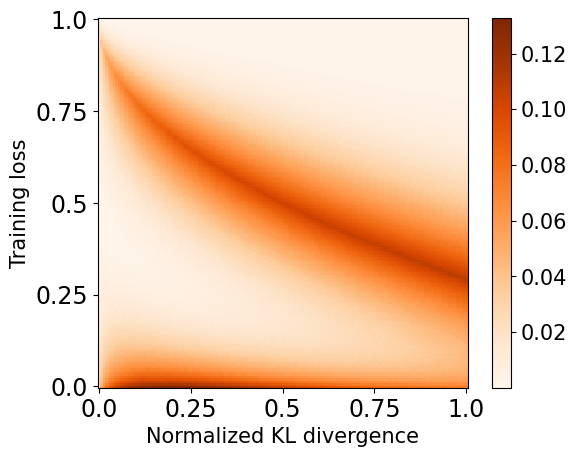

In [ ]:
# Plot the sub-Bernoulli discrepancy (Fig 1)
plot_heatmap( mlsfast , bound2=diffbounded, xmin=0.001, xmax = 1, Bmin = 0.001,
             Bmax = 1, cmap = cm.Oranges )

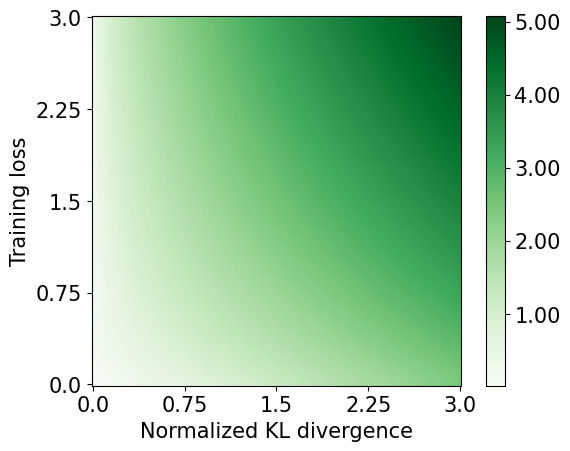

In [ ]:
# Plot the sub-Poissonian discrepancy (Fig 2)
plot_heatmap( ourpoisson , bound2=diffpoissonfast, cmap = cm.Greens )

<ipython-input-180-d296443e2cbb>:20: RuntimeWarning: divide by zero encountered in log
  klrange = q*np.log(q/Rrange) + (1-q)*np.log( (1-q)/(1-Rrange) )
<ipython-input-180-d296443e2cbb>:20: RuntimeWarning: invalid value encountered in multiply
  klrange = q*np.log(q/Rrange) + (1-q)*np.log( (1-q)/(1-Rrange) )


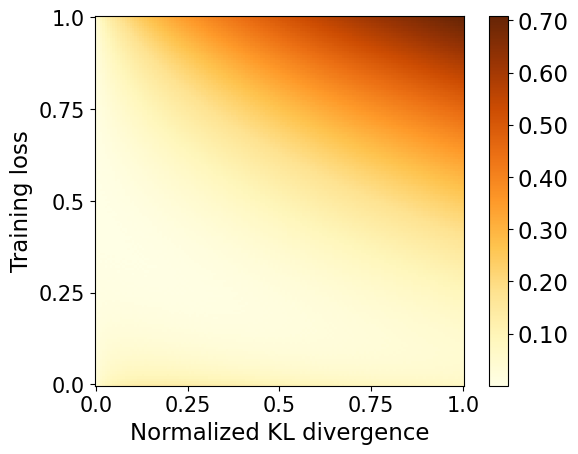

In [ ]:
# Plot the sub-Bernoulli discrepancy without minimum (Fig 3a)
plot_heatmap( mlsfast , bound2=diffbounded_nomin, xmin=0.001, xmax = 1,
             Bmin = 0.001, Bmax = 1, cmap = cm.YlOrBr, fontsize = 16.5 )

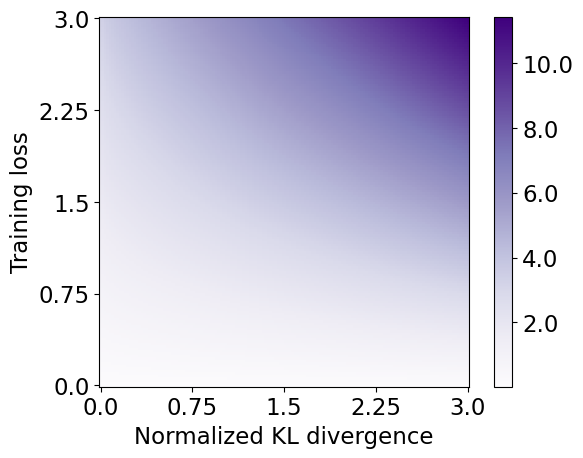

In [ ]:
# Plot our sub-gamma bound (Fig 3b)
plot_heatmap( ourgamma , cmap = cm.Purples, fontsize = 16.5, colorbarformat = '%.1f' )

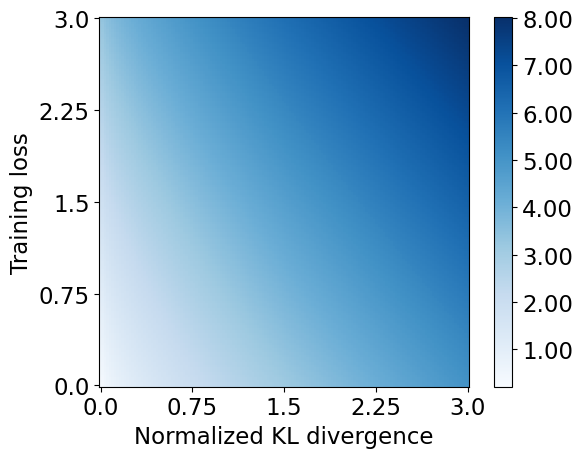

In [ ]:
# Plot our sub-Laplacian bound (Fig 3c)
plot_heatmap( ourlaplace , cmap = cm.Blues, fontsize = 16.5 )

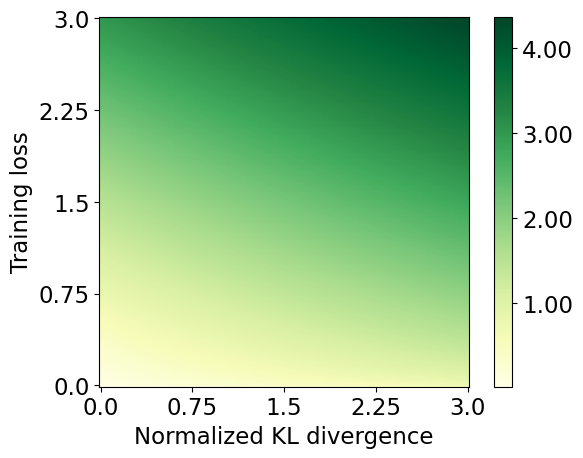

In [ ]:
# Plot our sub-Poissonian bound (without comparison, Fig 3d)
plot_heatmap( ourpoisson , cmap = cm.YlGn, fontsize = 16.5 )

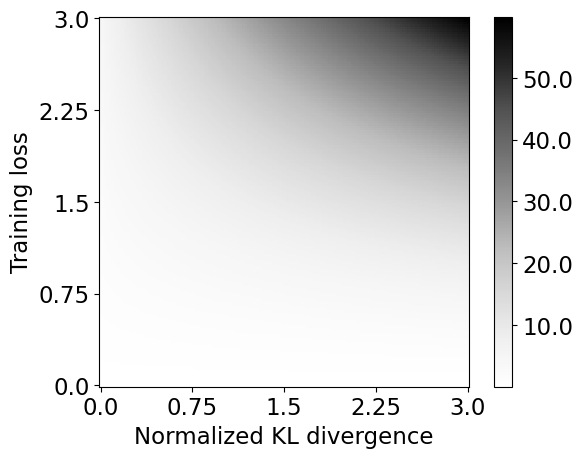

In [ ]:
# Plot our sub-inverse Gaussian bound (Fig 3e)
plot_heatmap( ourinvgauss , cmap = cm.Greys, fontsize = 16.5,
             colorbarformat = '%.1f' )

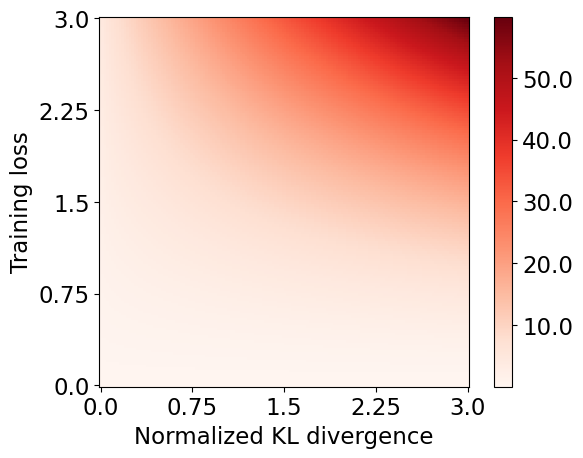

In [ ]:
# Plot our sub-negative binomial bound (Fig 3f)
plot_heatmap( ourinvgauss , cmap = cm.Reds, fontsize = 16.5,
             colorbarformat = '%.1f' )

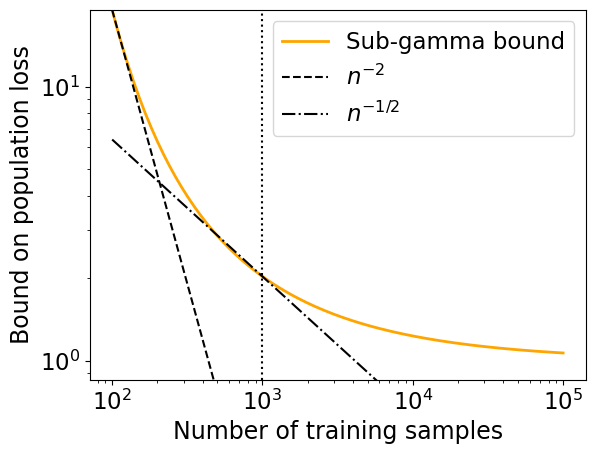

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the n-dependence for sub-gamma with training loss 1 (Fig 3a)
n_plot(ourgamma, trainloss = 1, boundlabel = 'Sub-gamma bound', initasymp = 2,
       KLasymp = 1/2 )

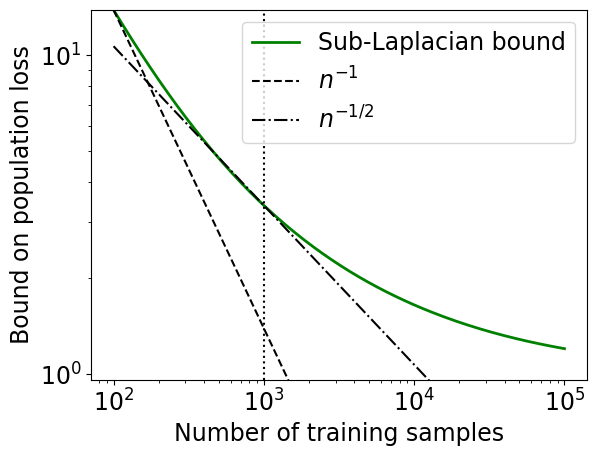

<Figure size 640x480 with 0 Axes>

In [ ]:
n_plot(ourlaplace, boundlabel = 'Sub-Laplacian bound', initasymp = 1,
       KLasymp = 1/2 ,plotcolor = 'green' )

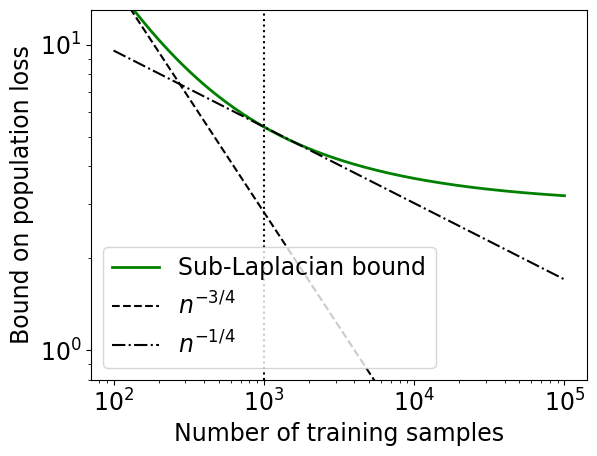

<Figure size 640x480 with 0 Axes>

In [ ]:
n_plot(ourlaplace, boundlabel = 'Sub-Laplacian bound', initasymp = 3/4,
       trainloss = 3, KLasymp = 1/4 ,plotcolor = 'green', ymin = 0.8, ymax = 13)